Import Libraries

In [ ]:
import sys
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import *

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import itertools
from keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preprocessing**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/household_power_consumption.txt', sep=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df1 = df
df1.shape

(2075259, 7)

In [ ]:
# Reduce the computation time
# Convert every minute data to hourly data
df_resample = df1.resample('h').mean()
df_resample.shape

(34589, 7)

In [ ]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [ ]:
# Adding meter values and dropping the redundant and unnecessary columns
df_resample['meter_value'] = df_resample['Sub_metering_1'] + df_resample['Sub_metering_2'] + df_resample['Sub_metering_3']
df_resample.drop(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Voltage', 'Global_reactive_power'], axis=1, inplace=True)
df_resample.head()

,Global_active_power,Global_intensity,meter_value
dt,,,
2006-12-16 17:00:00,4.222889,18.100000,17.388889
2006-12-16 18:00:00,3.632200,15.600000,23.583333
2006-12-16 19:00:00,3.400233,14.503333,18.116667
2006-12-16 20:00:00,3.268567,13.916667,16.783333
2006-12-16 21:00:00,3.056467,13.046667,17.633333


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)

	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))

		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	return agg

In [ ]:
values = df_resample.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.636816,0.631157,0.234246,0.545045
2,0.545045,0.541487,0.317692,0.509006
3,0.509006,0.502152,0.244050,0.488550
4,0.488550,0.481110,0.226089,0.455597
5,0.455597,0.449904,0.237539,0.322555


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time_1st = 365*24
n_train_time_3rd = 365*24*3

# Get all values of 3 year
train = values[n_train_time_1st:n_train_time_3rd, :]

# Get rest of the values
test = values[n_train_time_3rd:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] as expected by LSTMs
# train_X.shape[0] = rows
# train_X.shape[1] = columns
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17520, 1, 3) (17520,) (7879, 1, 3) (7879,)


1. LSTM

In [ ]:
# Define your model architecture
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# make a prediction yhat output
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 3))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Calculate R-squared (R2) score
r2 = r2_score(inv_y, inv_yhat)
print('R^2 Score: %.3f' % r2)

Epoch 1/50
274/274 - 11s - loss: 0.0117 - val_loss: 0.0077 - 11s/epoch - 38ms/step
Epoch 2/50
274/274 - 7s - loss: 0.0090 - val_loss: 0.0076 - 7s/epoch - 25ms/step
Epoch 3/50
274/274 - 5s - loss: 0.0089 - val_loss: 0.0076 - 5s/epoch - 18ms/step
Epoch 4/50
274/274 - 8s - loss: 0.0089 - val_loss: 0.0076 - 8s/epoch - 31ms/step
Epoch 5/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 21ms/step
Epoch 6/50
274/274 - 7s - loss: 0.0089 - val_loss: 0.0076 - 7s/epoch - 24ms/step
Epoch 7/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 21ms/step
Epoch 8/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 22ms/step
Epoch 9/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 23ms/step
Epoch 10/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 21ms/step
Epoch 11/50
274/274 - 6s - loss: 0.0089 - val_loss: 0.0076 - 6s/epoch - 23ms/step
Epoch 12/50
274/274 - 5s - loss: 0.0089 - val_loss: 0.0076 - 5s/epoch - 18ms/step
Epoch 13/50
274/274 - 6

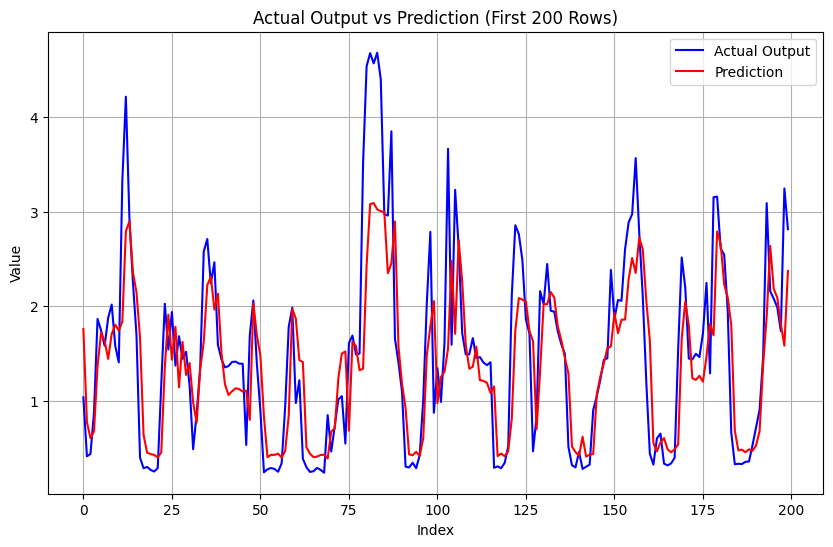

In [ ]:
# Create DataFrame with actual and predicted outputs
results_df = pd.DataFrame({'Actual': inv_y, 'Predicted': inv_yhat})

# Display the DataFrame
# results_df.head()

import matplotlib.pyplot as plt

# Plot the line graph for the first 200 rows
plt.figure(figsize=(10, 6))
plt.plot(results_df.index[:200], results_df['Actual'][:200], color='blue', label='Actual Output')
plt.plot(results_df.index[:200], results_df['Predicted'][:200], color='red', label='Prediction')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual Output vs Prediction (First 200 Rows)')
plt.legend()
plt.grid(True)
plt.show()

2. LSTM with K-Fold

In [ ]:
import pandas as pd

# Initialize lists to store RMSE and R2 scores
rmse_scores = []
r2_scores = []

# Initialize lists to store actual outputs and predictions
actual_outputs = []
predictions = []

n_splits = 5

def create_model():
    # Define your model architecture
    model = Sequential()
    model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True)
for fold_num, (train_index, test_index) in enumerate(kf.split(values)):
    train_fold, test_fold = values[train_index], values[test_index]

    train_fold_X, train_fold_y = train_fold[:, :-1], train_fold[:, -1]
    test_fold_X, test_fold_y = test_fold[:, :-1], test_fold[:, -1]

    train_fold_X = train_fold_X.reshape((train_fold_X.shape[0], 1, train_fold_X.shape[1]))
    test_fold_X = test_fold_X.reshape((test_fold_X.shape[0], 1, test_fold_X.shape[1]))

    model = create_model()
    history = model.fit(train_fold_X, train_fold_y, epochs=50, batch_size=64, verbose=0, shuffle=False)

    yhat_fold = model.predict(test_fold_X)
    test_fold_X = test_fold_X.reshape((test_fold_X.shape[0], 3))

    inv_yhat_fold = np.concatenate((yhat_fold, test_fold_X[:, -2:]), axis=1)
    inv_yhat_fold = scaler.inverse_transform(inv_yhat_fold)
    inv_yhat_fold = inv_yhat_fold[:,0]

    test_fold_y = test_fold_y.reshape((len(test_fold_y), 1))
    inv_y_fold = np.concatenate((test_fold_y, test_fold_X[:, -2:]), axis=1)
    inv_y_fold = scaler.inverse_transform(inv_y_fold)
    inv_y_fold = inv_y_fold[:,0]

    # Calculate RMSE and R2 score
    rmse_fold = np.sqrt(mean_squared_error(inv_y_fold, inv_yhat_fold))
    r2_fold = r2_score(inv_y_fold, inv_yhat_fold)

    # Append scores to lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

    # Store actual outputs and predictions
    actual_outputs.extend(inv_y_fold)
    predictions.extend(inv_yhat_fold)

    # Only consider first 200 rows for plotting
    if fold_num == 0:
        actual_first_200 = inv_y_fold[:200]
        predictions_first_200 = inv_yhat_fold[:200]

# Calculate average RMSE and R2 score
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

print('Average RMSE:', avg_rmse)
print('Average R^2 Score:', avg_r2)

214/214 [==============================] - 3s 7ms/step
Average RMSE: 0.6136224498931837
Average R^2 Score: 0.5323419246011252


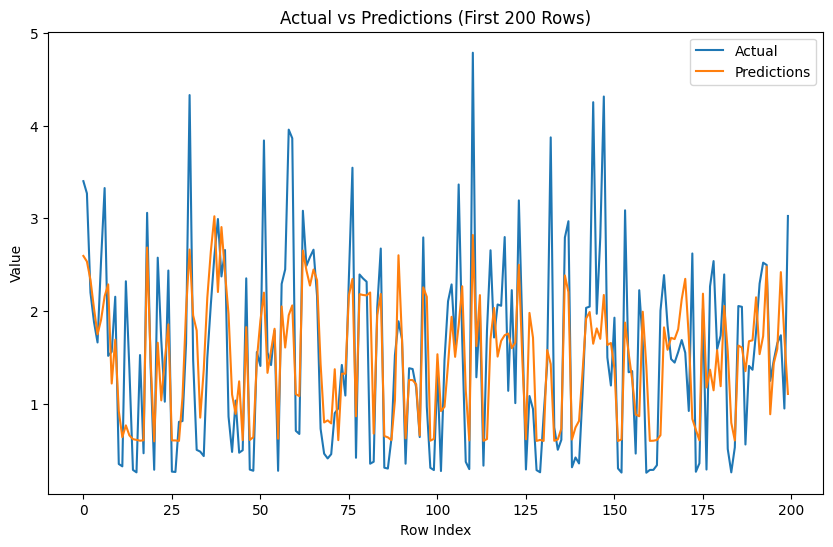

In [ ]:
# Create dataframe with actual outputs and predictions
df = pd.DataFrame({'Actual': actual_outputs, 'Predictions': predictions})

# Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(df.index[:200], df['Actual'][:200], label='Actual')
plt.plot(df.index[:200], df['Predictions'][:200], label='Predictions')
plt.xlabel('Row Index')
plt.ylabel('Value')
plt.title('Actual vs Predictions (First 200 Rows)')
plt.legend()
plt.show()

3. CNN with K-Fold

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

n_splits = 5

# Define your CNN model architecture
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))  # Adjust pooling size
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Initialize lists to store RMSE and R2 scores
rmse_scores = []
r2_scores = []

# Perform k-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in kf.split(values):
    train_fold, test_fold = values[train_index], values[test_index]

    train_fold_X, train_fold_y = train_fold[:, :-1], train_fold[:, -1]
    test_fold_X, test_fold_y = test_fold[:, :-1], test_fold[:, -1]

    train_fold_X = np.expand_dims(train_fold_X, axis=2)  # Add an extra dimension for Conv1D input
    test_fold_X = np.expand_dims(test_fold_X, axis=2)  # Add an extra dimension for Conv1D input

    input_shape = train_fold_X.shape[1:]  # Get input shape

    model = create_model(input_shape)
    history = model.fit(train_fold_X, train_fold_y, epochs=50, batch_size=64, verbose=0, shuffle=False)

    yhat_fold = model.predict(test_fold_X)

    rmse_fold = np.sqrt(mean_squared_error(test_fold_y, yhat_fold))
    rmse_scores.append(rmse_fold)

    r2_fold = r2_score(test_fold_y, yhat_fold)
    r2_scores.append(r2_fold)

# Calculate average RMSE and R2 score
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

print('Average RMSE:', avg_rmse)
print('Average R^2 Score:', avg_r2)

214/214 [==============================] - 0s 1ms/step
Average RMSE: 0.09531655222358797
Average R^2 Score: 0.5325089914517385


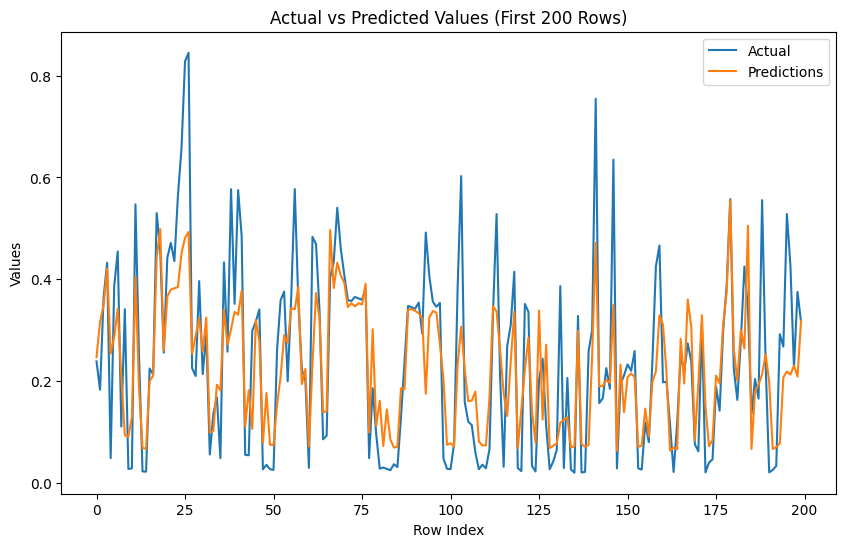

In [ ]:
df = pd.DataFrame({'Actual': test_fold_y.flatten(), 'Predictions': yhat_fold.flatten()})

plt.figure(figsize=(10, 6))
plt.plot(df.index[:200], df['Actual'][:200], label='Actual')
plt.plot(df.index[:200], df['Predictions'][:200], label='Predictions')
plt.xlabel('Row Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values (First 200 Rows)')
plt.legend()
plt.show()

4. CNN + LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Reshape, ZeroPadding1D

# Define your hybrid CNN-LSTM model architecture
def create_hybrid_model(input_shape):
    model = Sequential()
    # Pad the input sequence to ensure output size compatibility
    model.add(ZeroPadding1D(padding=(1, 1), input_shape=input_shape))
    # CNN layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    # LSTM layers
    model.add(Reshape((8, 8)))  # Reshape output of CNN for LSTM input
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize lists to store RMSE and R2 scores
rmse_scores = []
r2_scores = []

# Perform k-fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in kf.split(values):
    train_fold, test_fold = values[train_index], values[test_index]

    train_fold_X, train_fold_y = train_fold[:, :-1], train_fold[:, -1]
    test_fold_X, test_fold_y = test_fold[:, :-1], test_fold[:, -1]

    # Reshape train_fold_X to 2 dimensions before fitting the scaler
    train_fold_X_2d = train_fold_X.reshape(train_fold_X.shape[0], -1)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on training data
    scaler.fit(train_fold_X_2d)

    train_fold_X = train_fold_X.reshape((train_fold_X.shape[0], train_fold_X.shape[1], 1))
    test_fold_X = test_fold_X.reshape((test_fold_X.shape[0], test_fold_X.shape[1], 1))

    # Initialize the hybrid model
    model = create_hybrid_model((train_fold_X.shape[1], train_fold_X.shape[2]))

    # Train the model
    history = model.fit(train_fold_X, train_fold_y, epochs=50, batch_size=64, verbose=0, shuffle=False)

    # Make predictions
    yhat_fold = model.predict(test_fold_X)

    # Reshape test_fold_X to match yhat_fold's shape
    test_fold_X_reshaped = test_fold_X.reshape((test_fold_X.shape[0], test_fold_X.shape[1]))

    # Inverse scaling for predictions
    inv_yhat_fold = scaler.inverse_transform(np.concatenate((yhat_fold, test_fold_X_reshaped[:, -2:]), axis=1))[:, 0]

    # Inverse scaling for actual values
    inv_y_fold = scaler.inverse_transform(np.concatenate((test_fold_y.reshape(-1, 1), test_fold_X_reshaped[:, -2:]), axis=1))[:, 0]

    # Calculate RMSE and R2 score
    rmse_fold = np.sqrt(mean_squared_error(inv_y_fold, inv_yhat_fold))
    rmse_scores.append(rmse_fold)

    r2_fold = r2_score(inv_y_fold, inv_yhat_fold)
    r2_scores.append(r2_fold)


# Calculate average RMSE and R2 score
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

print('Average RMSE:', avg_rmse)
print('Average R^2 Score:', avg_r2)

214/214 [==============================] - 1s 3ms/step
Average RMSE: 0.09517953096840631
Average R^2 Score: 0.5327263631381696


     Actual  Predictions
0  0.301032     0.327580
1  0.273201     0.327844
2  0.501108     0.300746
3  0.376766     0.298673
4  0.278390     0.276574


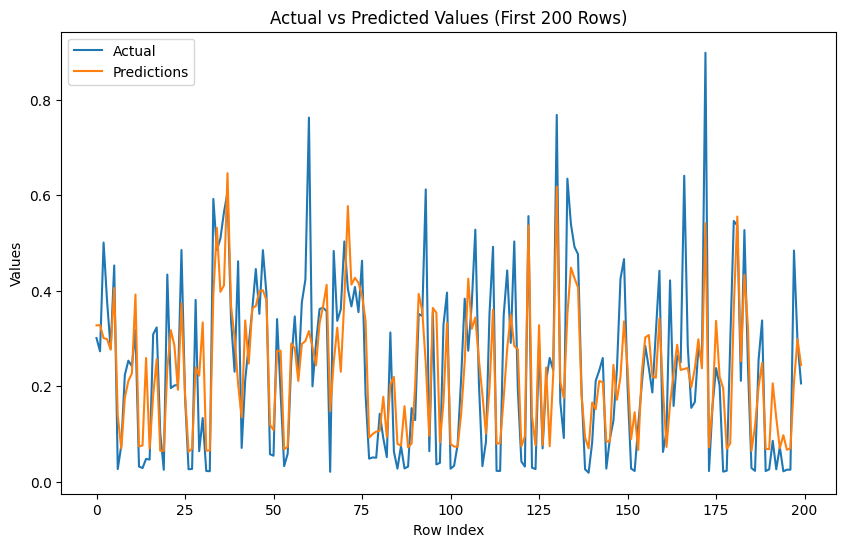

In [ ]:
# Create a dataframe with actual outputs and predictions
df = pd.DataFrame({'Actual': inv_y_fold, 'Predictions': inv_yhat_fold})

# Visualize the first 200 rows with a line graph
plt.figure(figsize=(10, 6))
plt.plot(df.index[:200], df['Actual'][:200], label='Actual')
plt.plot(df.index[:200], df['Predictions'][:200], label='Predictions')
plt.xlabel('Row Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values (First 200 Rows)')
plt.legend()
plt.show()

In [ ]:
# df_resample.set_index('dt', inplace=True)
df_resample.head()

,Global_active_power,Global_intensity,meter_value
dt,,,
2006-12-16 17:00:00,4.222889,18.100000,17.388889
2006-12-16 18:00:00,3.632200,15.600000,23.583333
2006-12-16 19:00:00,3.400233,14.503333,18.116667
2006-12-16 20:00:00,3.268567,13.916667,16.783333
2006-12-16 21:00:00,3.056467,13.046667,17.633333


In [ ]:
df_resample = pd.DataFrame(df_resample)
df_resample.dtypes

Global_active_power    float64
Global_intensity       float64
meter_value            float64
year                     int64
month                    int64
day                      int64
hour                     int64
dtype: object

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Assuming df_resample is your DataFrame with dt as the index
# Extract datetime features
df_resample['year'] = df_resample.index.year
df_resample['month'] = df_resample.index.month
df_resample['day'] = df_resample.index.day
df_resample['hour'] = df_resample.index.hour

# Prepare features and target variable
X = df_resample[['year', 'month', 'day', 'hour']]  # Include datetime features here
y = df_resample['Global_active_power']

# Drop rows with NaN values in y
df_resample.dropna(subset=['Global_active_power'], inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for NaN values in y_train
nan_indices_train = y_train.isna()

# Drop rows with NaN values in y_train
X_train = X_train[~nan_indices_train]
y_train = y_train[~nan_indices_train]

# Initialize and train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
# Calculate Root Mean Squared Error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Calculate R^2
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)


RMSE: 0.6499685006389219
R^2 Score: 0.4601133716459346


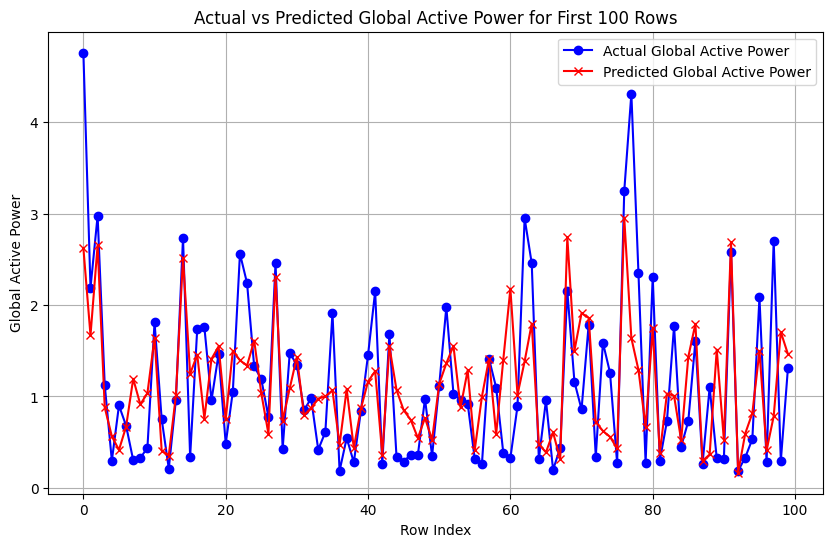

In [ ]:
import matplotlib.pyplot as plt

# Select the first 100 rows for plotting
num_rows = 100
index = range(num_rows)

# Extract actual and predicted values for the first 100 rows
actual_values = y_test[:num_rows]
predicted_values = predictions[:num_rows]

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(index, actual_values, label='Actual Global Active Power', marker='o', color='b')
plt.plot(index, predicted_values, label='Predicted Global Active Power', marker='x', color='r')
plt.xlabel('Row Index')
plt.ylabel('Global Active Power')
plt.title('Actual vs Predicted Global Active Power for First 100 Rows')
plt.legend()
plt.grid(True)
plt.show()

**5. Lasso Regression**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/household_power_consumption.txt',sep=";")

<ipython-input-42-e7ba98df5a9e>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/datasets/household_power_consumption.txt',sep=";")


In [ ]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
from sklearn.impute import SimpleImputer

# Converting string object types to numbers
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
df.replace(['?', 'nan', np.nan], -1, inplace=True)
num_vars= ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in num_vars:
    df[i] = pd.to_numeric(df[i])
imp = SimpleImputer(missing_values=-1, strategy='mean')
df[num_vars] = imp.fit_transform(df[num_vars])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [ ]:
# Target Variable
eq1 = (df['Global_active_power']*1000/60)
eq2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['power_consumption'] = eq1 - eq2
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import sklearn.metrics as skm
import pandas as pd

class lasmodel():
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def pre_processing(self):
        cat = ['Date', 'Time', 'power_consumption']
        X = self.df.drop(cat+[self.target], axis=1).values
        Y = self.df[self.target].values
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 72)
        return self

    def fit_pred_acc(self):
        reg = Lasso()
        reg.fit(self.X_train, self.Y_train)
        pred = reg.predict(self.X_test)
        mae = round(skm.mean_absolute_error(self.Y_test, pred), 2)
        rmse = round(skm.mean_squared_error(self.Y_test, pred, squared=False), 2)
        r2_score = round(skm.r2_score(self.Y_test, pred), 4)
        ev = round(skm.explained_variance_score(self.Y_test, pred), 4)
        return self.Y_test, pred, mae, rmse, r2_score, ev

las = lasmodel(df, 'Global_active_power')
las = las.pre_processing()
Y_test, pred, mae, rmse, r2_score, ev = las.fit_pred_acc()
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2_score}")

RMSE: 0.23
R2 Score: 0.9509


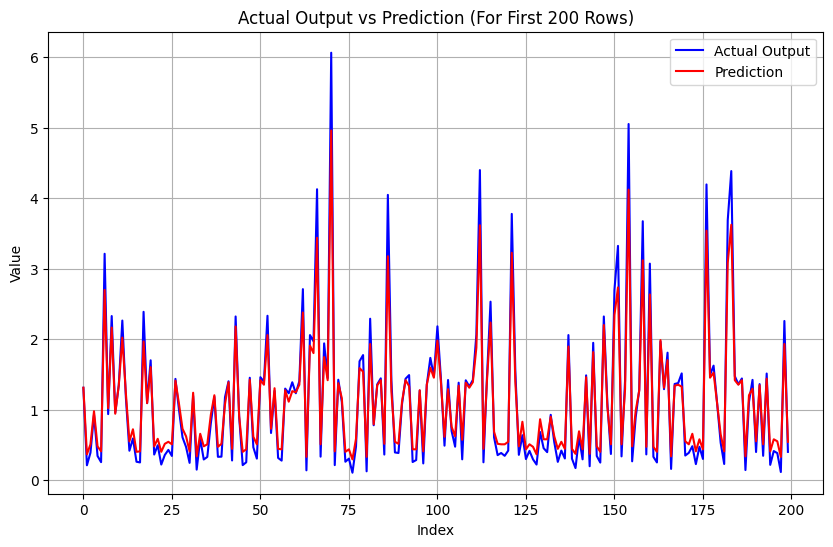

In [ ]:
# Create a DataFrame with actual output and prediction
result_df = pd.DataFrame({'Actual_Output': Y_test[:200], 'Prediction': pred[:200]})

import matplotlib.pyplot as plt

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Actual_Output'], color='blue', label='Actual Output')
plt.plot(result_df.index, result_df['Prediction'], color='red', label='Prediction')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual Output vs Prediction (For First 200 Rows)')
plt.legend()
plt.grid(True)
plt.show()